![banner](https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/banner.png?raw=true)


# Gumbel Softmax: Enabling Differentiable Categorical Sampling

#### Prereq
A prereq to this is you are already familiar with VAEs and VQ-VAEs, you can see my tutorial on that [here](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Vector_Quantized_Variational_AutoEncoders.ipynb)!

#### Recap VQVAE

Think back to our VQ-VAE setup. Our encoder takes data and compresses it down to a vector. We then compare this vector to a set of codes in our codebook and copy over whatever is closest. The decoder then gets these quantized codes to do its reconstruction task. What was the problem though? That entire $argmin$ operation is **NOT DIFFERENTIABLE**. So to train this model, we had to employ some tricks. 

1. Straight through gradient to copy our gradient information around the argmin
2. Codebook Loss to force codes to be close to encoder outputs
3. Commitment Loss to force encoder outputs to move towards the codes

#### Recap Reparameterization Trick

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/reparamaterization_trick.png?raw=true" alt="drawing" width="600"/>
![Image Source](https://sassafras13.github.io/ReparamTrick/)

In our VAE, when we sample from a distribution, the sampling process is not differentiable. Therefore we move our stochstic process outside of this so we can backprop! Take a look at my [VAE tutorial](https://github.com/priyammaz/PyTorch-Adventures/blob/main/PyTorch%20for%20Generation/AutoEncoders/Intro%20to%20AutoEncoders/Variational_AutoEncoders.ipynb) for more info on this!

#### Reformulate the Problem as Sampling

Lets think about this problem a little differently then. If our codebook has $K$ codes, our goal is to map our encoder output to one of these codes, and in VQ-VAE we select the code that has the smallest distance from the encoder output.

But, what if instead, we project our encoder output dimenion to $K$, compute the softmax over them and select the code with the highest probability? It's kind of like classification, we are trying to classify, for this specific encoder output, which of the $K$ codes is best! The problem though with this setup is again, the quantized codes will be passed on to the decoder, bur our selection of the best code is still an $argmax$ of the highest probability code. 

This is exactly what Gumbel-Softmax fixes. It allows for discrete sampling in a differentiable way! But before we go any deeper into this, we need to first explore and prove the Gumbel-Max trick. I will be following [this derivation](https://lips.cs.princeton.edu/the-gumbel-max-trick-for-discrete-distributions/) from the Princeton CS group, but fill in all the mathematical details they omitted!

## Gumbel-Max Trick

<img src="https://github.com/priyammaz/PyTorch-Adventures/blob/main/src/visuals/gumbel_max_trick.png?raw=true" alt="drawing" width="600"/>

Before we explore Gumbel-Softmax, we need to understand Gumbel-Max! It sounds fancy but it isn't. Something we have to do all the time is sample from a distribution. For example in LLMs, our goal is next token prediction. The way we typically do this is we create a probability vector over all the things that next token can be and then select a token based on that distribution. There are lots of ways to select this, 

1. Greedy Decoding: Select the token with the highest probability
2. Multinomial Sampling: Randomly sample a token with the computed distribution

Multinomial sampling is a very popular method but is a little slow because we have to do the following:
1. Get our raw logits from the model
2. Compute softmax over all the logits
3. Multionomial sample given that probability vector

We don't really care about the probability vector though. We just want to sample a single token from our categorical distribution. The Gumbel-Max trick is a reparamterization of this whole setup, and is the backbone for the more important Gumbel-Softmax we will get to later!

## What is the Gumbel Distribution?

I have said Gumbel a bunch, so lets define it now! This is a distribution (also known as Type-1 Generalized Extreme Value Distribution) that is used to model the maximums (or minimums). 

The CDF of the distribution is as follows:

$$F(x) = G(\mu, \beta) \sim \exp(-\exp(\frac{x-\mu}{\beta}))$$

$\mu$ is our parameter for the Mode of the distribution and $\beta$ is our scale parameter. Our standard Gumbel distribution will be $G(0,1)$, so it looks like:

$$F(x) = G(\mu, \beta) \sim \exp(-\exp(x))$$

We can easily get our PDF from here by just taking the derivative:

$$f(x) = F'(x) = e^{-e^{-x}}*(-e^{-x})*(-1) = e^{-x}e^{-e^{-x}}$$

### Applications of Gumbel Distribution

This is pretty popular for environmental science. For example, lets say you have a dataset of temperature every day. It is pretty likely that the temperature of a day is close to normally distributed:

$$T \sim N(\mu, \sigma)$$

And of course we have a dataset of these temperatures from every day:

$$[T_1, T_2, T_3, ..., T_N]$$

So the question I ask is: What is the distribution of:

$$\max(T_1, T_2, T_3, ..., T_N)$$

Each sample comes from a normal distribution, but we want to model the max over many samples. This is exactly what the Gumbel Distribution is modeling!



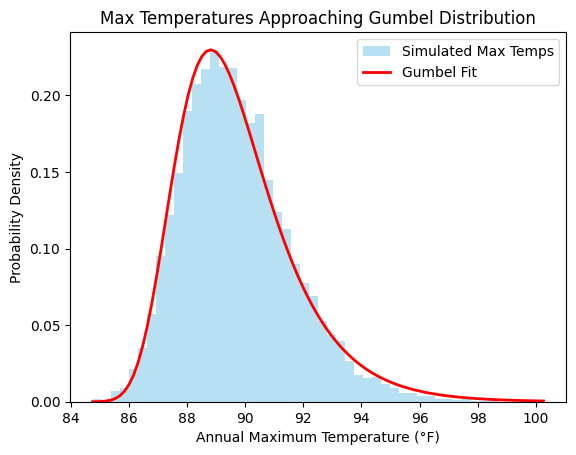

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
from scipy.stats import gumbel_r, norm
import matplotlib.pyplot as plt

### Generate Some Data ###
mu_temp = 75      
sigma_temp = 5    
days_per_year = 365
years = 10000     

### Simulate daily temperatures For Every Year ###
daily_temps = np.random.normal(mu_temp, sigma_temp, size=(years, days_per_year))

### Take the maximum temperature each year ###
annual_max = daily_temps.max(axis=1)

### Fit a Gumbel distribution to the maxima ###
params = gumbel_r.fit(annual_max)

# Plot histogram and Gumbel fit
x = np.linspace(min(annual_max), max(annual_max), 100)
plt.hist(annual_max, bins=50, density=True, alpha=0.6, color='skyblue', label="Simulated Max Temps")
plt.plot(x, gumbel_r.pdf(x, *params), 'r-', lw=2, label="Gumbel Fit")
plt.xlabel("Annual Maximum Temperature (°F)")
plt.ylabel("Probability Density")
plt.title("Max Temperatures Approaching Gumbel Distribution")
plt.legend()
plt.show()


So if we can use Gumbel Distributions to model the Max of something, it kind of makes sense that we can use it to model our $argmax$ as well! The Gumbel Max trick takes advantage of exactly this! Here is the setup for the Gumbel Max trick:

If we have some logit outputs from our neural network, add some standard gumbel noise to it and take the argmax, this should be equivalent to having taken the softmax of the logits and then sample from a multinomial distribution. 

## Gumbel-Max Trick Proof

Show that Gumbel-Max trick is equivalent to sampling from probabilities generated via softmax. 

Let our raw outputs from the neural network be denoted as $o_i$

$$\text{if } Y = \underset{i}{\operatorname{argmax}}\{o_i + g_i\}$$
$$\text{where }g_i \sim G(0,1)$$
$$\text{Show that }P(Y=i) = \frac{e^{o_i}}{\sum_j{e^{o_j}}}$$

#### Gumbel Shift Property

Like Normal distributions, if we add something to a Gumbel Distribution it just shift our $\mu$ parameter. So if we have:

$$x\sim G(0,1)$$

and we add a constant to $x$ we will get:

$$x+c \sim G(c,1)$$

So lets use that to our advantages and star tthe setup for the problem, if we are adding randomly sampled gumbel noise $g_i$ to our logit $o_i$ we can then write that the distribution is:

$$o_i + g_i \sim G(o_i, 1)$$

Lets write that $z_i = o_i + g_i$. What is then the CDF of $z_i$?

$$P(z_i<z) = P(o_i + g_i < z) = P(g_i < z - o_i) = F(z-o_i)$$

Where F is the CDF of the gumbel distribution. 

#### Step 1: Express P(Y=k)

If we say that $y=k$, that implies that $Z_k > Z_j \forall j\neq k$. This means that if $z_k$ is equal to some $z$, all $z_j$ must be less than $z$. 

So we can break this up, the probability of $z_k=z$ is our PDF and can be written as $f(z-o_k)$ and for all other $z_j$ where $j \neq k$ it must be les than $z$, so $z_j < z$ is a CDF and can be written as $F(z-o_j)$.

Each $z_i$ is iid so the overall probability is the product of all the events, where $z_k=z$ and $z_j<z$ for all $j \neq k$. This is possible for any value of $z$, so we sum (integrate) over all possibilites of $z$.

$$P(y=k) = \int_{-\infty}^{\infty}f(z-o_k)\prod_{j\neq k}F(z-o_j)dz$$

Lets grab our formulations for $f(z-o_k)$ and $F(z-o_j)$:

$$f(z-o_k) = e^{-(z-o_k)}e^{-e^{z-o_k}}$$
$$\prod_{j\neq k}F(z-o_j) = e^{-\sum_{j \neq k}e^{-(z-o_j)}}$$

So all together we get:

$$P(y=k) = \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-e^{z-o_k}}e^{-\sum_{j \neq k}e^{-(z-o_j)}}dz$$
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-(e^{z-o_k} + \sum_{j \neq k}e^{-(z-o_j)})}dz$$
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-\sum_{j}e^{-(z-o_j)}}dz$$

For simplicy, let $s(z) = \sum_{j}e^{-(z-o_j)}$

So we finally have:
$$= \int_{-\infty}^{\infty}e^{-(z-o_k)}e^{-s(z)}dz$$

Its time to integrate! Lets do a quick variable substitution:

$$u = z - o_k \implies z = u + o_k$$
$$dz = du$$
$$z \rightarrow \infty, u \rightarrow \infty$$
$$z \rightarrow -\infty, u \rightarrow -\infty$$

So doing this substituion we get:

$$= \int_{-\infty}^{\infty}e^{-u}e^{-s(u+o_k)}du$$

Lets take a look at $s(u+o_k)$. 

If
$$s(z) = \sum_{j}e^{-(z-o_j)}$$ 

then 

$$s(u+o_k) = \sum_{j}e^{-(u+o_k-o_j)}$$
$$= \sum_{j}e^{-u}e^{o_j-o_k}$$
$$= e^{-u}\sum_{j}e^{o_j-o_k}$$

Again, for simplicty let: 
$$t = \sum_{j}e^{o_j-o_k} = \frac{\sum_{j}e^{o_j}}{e^{o_k}}$$

Hmmm, thats starting to look like a softmax! Exciting!

So we can now write:

$$s(u+o_k) = e^{-u}t$$

So using our new variable t, lets just rewrite our integral

$$= \int_{-\infty}^{\infty}e^{-u}e^{-e^{-u}t}du$$

One more variable substitution!

$$v = e^{-u} \implies u = -log(v)$$
$$du = -\frac{dv}{v}$$
$$u \rightarrow \infty, v \rightarrow 0$$
$$u \rightarrow -\infty, v \rightarrow \infty$$

$$= \int_{\infty}^{0}-ve^{-tv}\frac{dv}{v}$$
$$= \int_{\infty}^{0}-e^{-tv}dv$$
$$= \int_{0}^{\infty}e^{-tv}dv$$
$$= -\frac{1}{t}\left[e^{-tv}\right]_0^{\infty}$$
$$= -\frac{1}{t}(0 - 1)$$
$$= \frac{1}{t}$$

and we know that:

$$t = \sum_{j}e^{o_j-o_k} = \frac{\sum_{j}e^{o_j}}{e^{o_k}}$$

Therefore our final result is:
$$P(y=k) = \frac{e^{o_k}}{\sum_{j}e^{o_j}}$$

That looks like softmax to me! So we have shown that adding standard gumbel noise to our logits and doing an argmax is equivalent to have taken a softmax and randomly sampled with that distribution! 

### Sampling from a Gumbel Distribution

One other thing we need to do is know how to actually generate $g_i$. For example, when we want to generate gaussian noise we can use ```torch.randn```. Similarly torch also has an inbuilt ```torch.distributions.gumbel.Gumbel``` that we can use, but lets just implement the sampling process ourselves because thats more fun!

We are going to keep it simple and just generate Standard Gumbel Noise with $\mu=0$ and $\beta=1$. 

#### Inverse Transform Sampling (CDF Method)

Sampling from distributions that are invertible is pretty easy! Think about it this way:

The CDF of a distribution can only take values between 0 and 1, we will use the notation $\left[0, 1\right]$. So this means we can write:

$$F(x) \in  \left[0, 1\right]$$

Now what we want is to sample $x$ from this distribution, so what if we do the following:

$$F^{-1}\left[F(x)\right] \in  F^{-1}\left[\left[0, 1\right]\right]$$
$$x \in  F^{-1}\left[\left[0, 1\right]\right]$$

Now ofcourse, this will only work **IF** our CDF $F(x)$ is actually invertible, which isn't true for lots of distributions. But luckily, for our Gumbel CDF, this is totally fine!

$$F(x)\in \left[0, 1\right] = U \sim \exp(-\exp(x))$$

Then we can take the inverse and get $x$ on one side and $U$ on the other:

$$-\log(-\log(U)) \sim x$$

Now we know that $U$ must be between 0 and 1 (as that is the CDF restriction). What other distribution do we know that is between 0 and 1? Uniform! So we can use the CDF method here
to randomly sample a value between 0 and 1 with a uniform distribution, and then use our Inverse CDF to actually get a sample from the Gumbel Distribution we care about!

#### What if there is no Inverse?

Well, it gets tougher. For example Sampling from a gaussian distribution uses the Box Muller trick, but I don't want to deviate too much from what we are doing here today!

#### Visual Proof

Just to make sure we can verify this, lets go ahead and apply our Gumbel Max estimator on some logits, and compare to softmax to ensure we get similar results regardless!

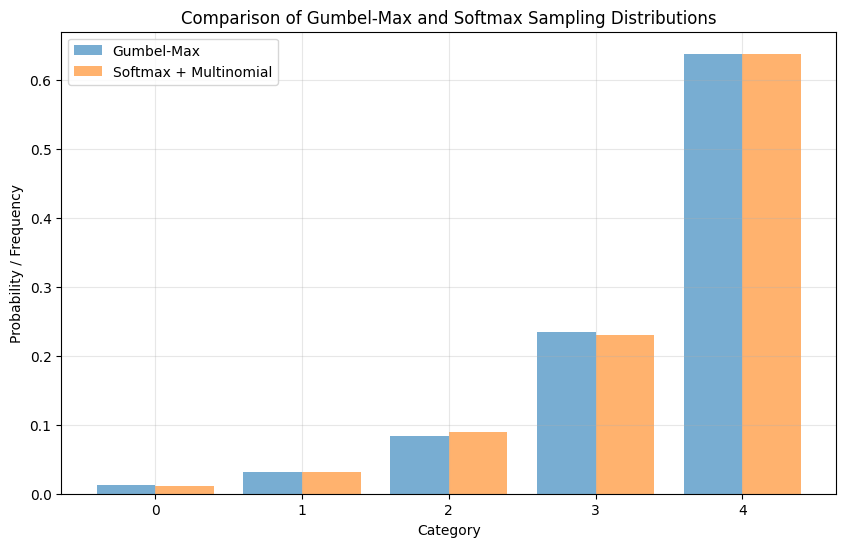

In [2]:
# Define logits for a categorical distribution with 5 categories
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0])

# Number of samples to generate
num_samples = 10000

# Function to sample using Gumbel-Max trick
def gumbel_max_sample(logits, num_samples):

    # Generate Gumbel noise: -log(-log(U)), U ~ Uniform(0,1)
    uniform = torch.rand(num_samples, len(logits))
    
    gumbel = -torch.log(-torch.log(uniform + 1e-20))  
    
    # Add noise to logits and take argmax
    perturbed_logits = logits + gumbel
    samples = torch.argmax(perturbed_logits, dim=1)
    return samples

# Function to sample using softmax + multinomial
def softmax_sample(logits, num_samples):
    # Compute softmax probabilities
    probs = torch.softmax(logits, dim=0)
    # Sample from categorical distribution
    samples = torch.multinomial(probs, num_samples, replacement=True)
    return samples

# Generate samples
gumbel_samples = gumbel_max_sample(logits, num_samples)
softmax_samples = softmax_sample(logits, num_samples)

# Compute empirical frequencies
gumbel_counts = torch.bincount(gumbel_samples, minlength=len(logits)) / num_samples
softmax_counts = torch.bincount(softmax_samples, minlength=len(logits)) / num_samples

# Compute theoretical softmax probabilities
probs = torch.softmax(logits, dim=0)

# Plotting
categories = torch.arange(len(logits))
plt.figure(figsize=(10, 6))
plt.bar(categories - 0.2, gumbel_counts, width=0.4, label='Gumbel-Max', alpha=0.6)
plt.bar(categories + 0.2, softmax_counts, width=0.4, label='Softmax + Multinomial', alpha=0.6)
plt.xlabel('Category')
plt.ylabel('Probability / Frequency')
plt.title('Comparison of Gumbel-Max and Softmax Sampling Distributions')
plt.legend()
plt.grid(True, alpha=0.3)
plt.savefig('gumbel_max_comparison.png')
plt.show()

### Moving to Gumbel-Softmax

Ok, we now have a new way of sampling from a distribution, but it still doesn't solve our issue of computing derivatives! We still have an $argmax$ operation:

$$Y = \underset{i}{\operatorname{argmax}}\{o_i + g_i\}$$

So what if we replace our $argmax$ with something differentiable? The proposal from the paper is to use a *softmax relaxation*, giving us the **Gumbel-Softmax distribution**:
$$
y_i = \frac{\exp\!\left(\tfrac{o_i + g_i}{\tau}\right)}
           {\sum_j \exp\!\left(\tfrac{o_j + g_j}{\tau}\right)}
$$

Here, $\tau$ is a temperature parameter that controls how "sharp" the distribution is.  

- When $\tau$ is large, the distribution approaches Uniform.  
- When $\tau$ is small, $y$ becomes nearly one-hot, and as $\tau \to 0$, it converges in distribution to a one-hot vector sampled from the original categorical $p(i)$.  

It is pretty common to start temperature at a relatively high value at the beginning of training when the model doesn't know anything. This makes it more random in selecting an quantized embedding vector. But as the model improves, we want it to commit to the quantized embeding that is best, so we will decay the temperature over the training run, so it becomes more one-hot

---

### KEY TAKEAWAY 

#### Original Distribution (the categorical we want)
We start with logits $o = (o_1, o_2, \dots, o_K)$. These define our categorical distribution:

$$p(i) = \frac{e^{o_i}}{\sum_j e^{o_j}}$$

Our goal: draw a random sample according to this distribution.

#### Gumbel-Max
A trick to sample exactly from $p(i)$ using Gumbel noise:

$$
Y = \underset{i}{\operatorname{argmax}}\{o_i + g_i\}.
$$

#### Gumbel-Softmax
A differentiable relaxation: instead of a hard $argmax$, we use a softmax with temperature $\tau$:

$$
y_i = \frac{\exp\!\left(\tfrac{o_i + g_i}{\tau}\right)}{\sum_j \exp\!\left(\tfrac{o_j + g_j}{\tau}\right)}.
$$

- As $\tau \to 0$, $y$ becomes one-hot and recovers the categorical distribution $p(i)$.  
- As $\tau \to \infty$, $y$ approaches the uniform distribution.  

Therefore, Gumbel-Softmax provides a smooth approximation of categorical sampling that is differentiable and useful for gradient-based learning.

### How to Get One-Hot-Vectors

So in the end, this method returns a probability distribution. And as $\tau$ gets smaller, one of the categories will have nearly 100% of the probability, with close to 0% elsewhere (thus our categorical approximation). But its still not perfectly one-hot, and we need that as we want to select a single embedding vector from our codebook. So what we can do is take an argmax here to get one-hot vectors (with the index placed on the category with the largest probability), and then copy the gradients over so its a straight through estimator (STE) just like we saw in the VQ-VAE!

- **Forward Pass**: discretize y into a one-hot-encoded vector by taking an argmax

- **Backward Pass**: we basically pretend we didn't discretize and just pass gradients through our original soft y.

### Lets Implement It!

In [3]:
def gumbel_softmax(logits, 
                   tau=1, 
                   hard=False, 
                   eps=1e-10, 
                   dim=-1):

    ### Sample Uniform Gumbel Noise -log(-log(U))
    rand_uniform = torch.rand_like(logits, device=logits.device)
    gumbels = -torch.log(
        -torch.log(
            rand_uniform + eps
        ) + eps
    )

    ### Compute Gumbel Softmax ###
    y = F.softmax(
        (logits+gumbels) / tau, dim=dim
    )

    ### Straight Through Estimator for hard ###
    if hard:
        y_hard = torch.zeros_like(y, device=y.device)
        max_idx = y.argmax(dim=dim, keepdim=True)
        y_hard.scatter_(dim, max_idx, 1.0)

        ### STE ###
        y = y + (y_hard - y).detach()

    return y

### Plot The Effects of Tau

Lets see what Tau Does to our distribution!

True Distribution: tensor([0.0117, 0.0317, 0.0861, 0.2341, 0.6364])


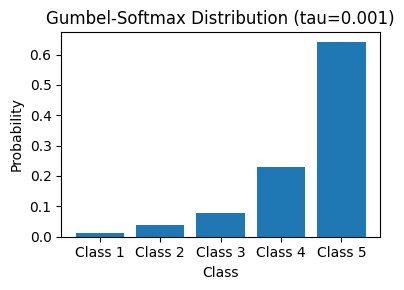

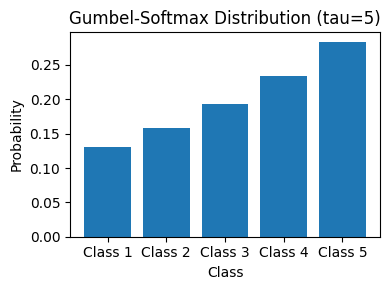

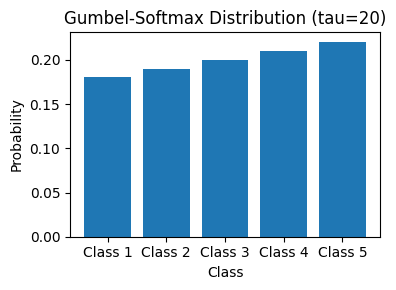

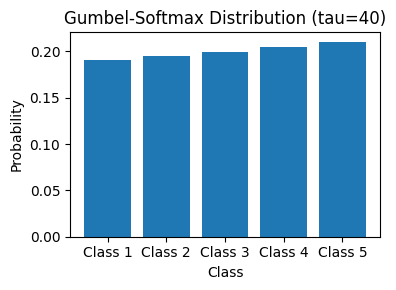

In [4]:
# Parameters
num_samples = 1000
tau_values = [0.001, 5, 20, 40]
logits = torch.tensor([1.0, 2.0, 3.0, 4.0, 5.0]) 
print("True Distribution:", logits.softmax(dim=-1))
device = torch.device('cpu')
logits = logits.to(device)

# Generate distributions and create separate plots
for tau in tau_values:
    samples = []
    for _ in range(num_samples):
        y = gumbel_softmax(logits, tau=tau, hard=False, dim=-1)
        samples.append(y)
    mean_probs = torch.mean(torch.stack(samples), dim=0).numpy()

    # Create individual plot
    fig, ax = plt.subplots(figsize=(4, 3))
    x = np.arange(5)
    ax.bar(x, mean_probs)
    ax.set_xlabel('Class')
    ax.set_ylabel('Probability')
    ax.set_title(f'Gumbel-Softmax Distribution (tau={tau})')
    ax.set_xticks(x)
    ax.set_xticklabels([f'Class {i+1}' for i in range(5)])
    plt.tight_layout()

    plt.show()

Its pretty clear that as our Tau gets larger, the distribution becomes closer and closer to uniform!

### Train a Model

We will use our Convolutional VQ-VAE as a starting point and replace our original embedding lookup with our new Gumbel Softmax Quantization!

In [5]:
class GumbelSoftmaxQuantizer(nn.Module):
    def __init__(self, codebook_size, embedding_dim):
        super(GumbelSoftmaxQuantizer, self).__init__()
        self.codebook_size = codebook_size
        self.embedding_dim = embedding_dim
        self.tau = 2.0

        self.proj = nn.Linear(embedding_dim, codebook_size)
        self.embeddings = nn.Embedding(codebook_size, embedding_dim)

    def forward(self, x):

        batch_size_flat = x.shape[0]

        logits = self.proj(x)

        ### When Training we need differentiable sampling ###
        if self.training:
            ohe_codes = gumbel_softmax(logits, tau=self.tau, hard=True)
        else:
            ohe_codes = torch.zeros_like(logits, device=logits.device)
            max_idx = logits.argmax(dim=-1, keepdim=True)
            ohe_codes.scatter_(-1, max_idx, 1.0)

        quantized = torch.matmul(ohe_codes, self.embeddings.weight)

        return quantized, ohe_codes

class ConvolutionalGumbelVAE(nn.Module):
    def __init__(self, in_channels=1, latent_dim=4, codebook_size=512, tau=1.0, hard=False):
        super(ConvolutionalGumbelVAE, self).__init__()

        self.bottleneck = latent_dim
        self.in_channels = in_channels 
        self.codebook_size = codebook_size
        
        self.encoder_conv = nn.Sequential(
            ### Convolutional Encoding ###
            nn.Conv2d(in_channels=in_channels, out_channels=8, kernel_size=5, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(8),
            nn.ReLU(), 

            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(16),
            nn.ReLU(), 

            nn.Conv2d(in_channels=16, out_channels=self.bottleneck, kernel_size=3, stride=2, padding=1, bias=False), 
            nn.BatchNorm2d(self.bottleneck),
            nn.ReLU(),
        )

        ### Gumbel-Softmax Quantizer ###
        self.vq = GumbelSoftmaxQuantizer(codebook_size, latent_dim)
        
        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.bottleneck, out_channels=16, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(), 
            
            nn.ConvTranspose2d(in_channels=16, out_channels=8, kernel_size=3, stride=2, padding=1, output_padding=1, bias=False),
            nn.BatchNorm2d(8),
            nn.ReLU(),
            
            nn.ConvTranspose2d(in_channels=8, out_channels=in_channels, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )
    
    def forward_enc(self, x):
        batch_size, num_channels, height, width = x.shape
        conv_enc = self.encoder_conv(x)
        return conv_enc

    def quantize(self, z):
        # z shape: (batch_size * height * width, bottleneck)
        quantized, ohe_codes = self.vq(z)
        return quantized, ohe_codes

    def forward_dec(self, x):
        batch_size, channels, height, width = x.shape

        ### Reshape B x C x H x W -> B*H*W x C ###
        x = x.permute(0, 2, 3, 1)
        x = torch.flatten(x, start_dim=0, end_dim=-2)

        ### Quantize Data ###
        quantized, ohe_codes = self.quantize(x)

        ### Reshape Back to B x C x H x W ###
        quantized = quantized.reshape(batch_size, height, width, channels)
        quantized = quantized.permute(0, 3, 1, 2)
        
        conv_dec = self.decoder_conv(quantized)
        
        return quantized, conv_dec, ohe_codes
        
    def forward(self, x):
        batch_size, num_channels, height, width = x.shape
        latents = self.forward_enc(x)
        quantized_latents, decoded, ohe_codes = self.forward_dec(latents)
        return latents, quantized_latents, decoded, ohe_codes
        
        

### Train Model

Simply training script that also linearly anneals our Tau values!

In [6]:
def train(model, 
          train_set, 
          test_set, 
          batch_size, 
          training_iterations, 
          evaluation_iterations,
          tau_start=1.0,
          tau_end=0.5,
          pct_decay_steps=0.5):
    
    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = model.to(device)
    
    trainloader = DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=8)
    testloader = DataLoader(test_set, batch_size=batch_size, shuffle=False, num_workers=8)

    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    train_losses = []
    evaluation_losses = []
    
    # Linear tau decay schedule over training_iterations (batches)
    decay_steps = int(pct_decay_steps * training_iterations)
    tau_decay = np.linspace(tau_start, tau_end, decay_steps)
    tau_constant = np.full(training_iterations - decay_steps, tau_end)
    tau_schedule = np.concatenate([tau_decay, tau_constant])
    
    step = 0
    pbar = tqdm(total=training_iterations)
    
    while step < training_iterations:
        model.train()
        for images, labels in trainloader:
            if step >= training_iterations:
                break
                
            # Update tau
            model.vq.tau = tau_schedule[step]
            
            # Training step
            images = images.to(device)
            latents, quantized_latents, decoded, ohe_codes = model(images)
            loss = torch.mean((images - decoded) ** 2)
            train_losses.append(loss.item())
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            pbar.set_description(f"Train Loss: {train_losses[-1]:.4f}, Tau: {model.vq.tau:.4f}")
            pbar.update(1)
            step += 1
            
            # Evaluation
            if step % evaluation_iterations == 0 or step == training_iterations:
                model.eval()
                eval_loss = 0.0
                encoded_evaluations = []
                quantized_encoded_evaluations = []
                
                with torch.no_grad():
                    for images, labels in testloader:
                        images = images.to(device)
                        latents, quantized_latents, decoded, ohe_codes = model(images)
                        loss = torch.mean((images - decoded) ** 2)
                        eval_loss += loss.item() / len(testloader)
                
                evaluation_losses.append(eval_loss)
    
    pbar.close()
    print("Completed Training!")
    print(f"Final Training Loss: {train_losses[-1]:.4f}")
    print(f"Final Evaluation Loss: {evaluation_losses[-1]:.4f}")
    
    return model, train_losses, evaluation_losses

In [9]:
tensor_transforms = transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor()
    ]
)
train_set = MNIST("../../../data/mnist/", train=True, transform=tensor_transforms)
test_set = MNIST("../../../data/mnist/", train=False, transform=tensor_transforms)


model = ConvolutionalGumbelVAE()
model, train_losses, evaluation_losses= train(model,
                                              train_set=train_set,
                                              test_set=test_set,
                                              batch_size=64,
                                              training_iterations=25000,
                                              evaluation_iterations=250)



  0%|          | 0/25000 [00:00<?, ?it/s]

Completed Training!
Final Training Loss: 0.0250
Final Evaluation Loss: 0.0239


## Results!

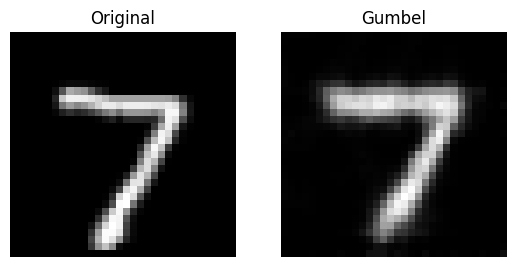

In [10]:
generated_index = 0
image, label = test_set[generated_index]
image = image.unsqueeze(0).to("cuda")
model.eval()

with torch.no_grad():
    _,_,reconstruction, _ = model(image)

fig, ax = plt.subplots(1,2)

ax[0].imshow(image.cpu().squeeze(), cmap="gray")
ax[0].set_title("Original")
ax[0].set_xticklabels([])
ax[0].set_yticklabels([])
ax[0].axis("off")

ax[1].imshow(reconstruction.cpu().squeeze(), cmap="gray")
ax[1].set_title("Gumbel")
ax[1].set_xticklabels([])
ax[1].set_yticklabels([])
ax[1].axis("off")

plt.show()


We can see we get pretty good reconstruction! Typically we will have additional losses that we add to these models to promote codebook utilization (and help with index collapse), but for datasets like MNIST this isn't a huge issue. We get a feel for differentiable sampling now, and this sets us up for important architectures in the future, like Wav2Vec2 that leverages Gumbel-Softmax to quantize audio embeddings!